## Find best model to detect rip current

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_images(folder_path):
    images = []
    for file in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, file))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return images

def load_labels(folder_path):
    labels = []
    for file in os.listdir(folder_path):
        with open(os.path.join(folder_path, file), 'r') as f:
            data = f.readline().strip().split(' ')
            values = [float(value) for value in data[0:]] #data[1:]]
            labels.append(values)
    return labels

def show_data(image, labels):
    image = image
    label = labels
    image_bbox = image.copy()
    cls, x, y, w, h = labels
    x1, y1 = int((x - w / 2) * image.shape[1]), int((y - h / 2) * image.shape[0])
    x2, y2 = int((x + w / 2) * image.shape[1]), int((y + h / 2) * image.shape[0])
    
    plt.imshow(image)
    plt.title('test')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2))
    plt.show()

In [3]:
# def load_test(file_path):
#     with open(file_path, 'r') as f:
#         data = f.readline().strip().split(' ')
#     return data

In [4]:
# data = np.array(load_test('test_file.txt')).astype('float32')

In [5]:
data_dir = 'data/dataset0/'
# data_dir = 'datasets/mnist/'

In [6]:
train_images = np.array(load_images(data_dir + 'train/images'))#.astype('float32')
train_labels = np.array(load_labels(data_dir + 'train/labels'))#.astype('float32')
valid_images = np.array(load_images(data_dir + 'valid/images'))#.astype('float32')
valid_labels = np.array(load_labels(data_dir + 'valid/labels'))#.astype('float32')

In [7]:
test_images = load_images(data_dir + 'test/images')
test_labels = load_labels(data_dir + 'test/labels')

In [8]:
np_test_images = np.array(test_images)
np_test_labels = np.array(test_labels)

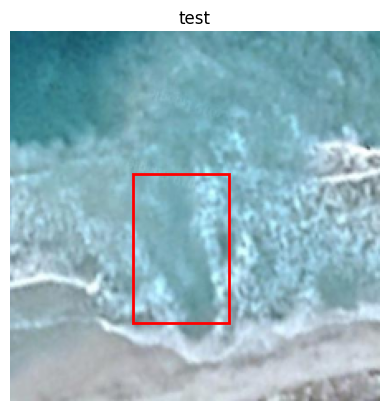

In [9]:
show_data(train_images[3], train_labels[3])

In [10]:
ex_idx = 0
print("train images:", train_images.shape)
# print("train image ex:\n", train_images[ex_idx])
print("train labels:", np.shape(train_labels))
# print("train label ex:\n", train_labels[ex_idx])
print("valid images:", valid_images.shape)
# print("valid image ex:\n", valid_images[ex_idx])
print("valid labels:", valid_labels.shape)
# print("valid label ex:\n", valid_labels[ex_idx])

train images: (984, 224, 224, 3)
train labels: (984, 5)
valid images: (280, 224, 224, 3)
valid labels: (280, 5)


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, {'class_predictions': train_labels[:, 0], 'box_predictions': train_labels[:, 1:]}))
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((valid_images, {'class_predictions': valid_labels[:, 0], 'box_predictions': valid_labels[:, 1:]}))
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2023-07-24 08:07:54.423182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 08:07:54.540699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 08:07:54.541204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Reshape, Dropout, GlobalAveragePooling2D, Dense, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2
from tensorflow.keras.losses import Huber
from keras.regularizers import l2

2023-07-24 08:07:49.876220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 08:07:51.863362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### MobilenetV3

In [13]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False #base model as feature ex

In [125]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
class_model = Dense(1, activation='softmax', name='class_predictions')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(base_model.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
box_model = Dense(4, name='box_predictions')(x)

model = Model(inputs=base_model.input, outputs=[class_model, box_model])

In [126]:
losses = {
    'class_predictions': 'binary_crossentropy',
#     'box_predictions': Huber(delta=4.0)
    'box_predictions': 'mean_squared_error'
}

In [127]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=losses, metrics='accuracy')

In [128]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

 box_predictions (Dense)        (None, 4)            516         ['dropout_3[0][0]']              
                                                                                                  
Total params: 7,141,829
Trainable params: 4,883,845
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


In [129]:
# history = model.fit(
#     train_images, 
#     train_labels, 
#     validation_data=(valid_images, valid_labels), 
#     epochs=40)

history = model.fit(train_dataset, epochs=80, validation_data=val_dataset)

Epoch 1/80
31/31 [==============================] - 9s 163ms/step - loss: 0.7838 - class_predictions_loss: 0.1545 - box_predictions_loss: 0.6294 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.2348 - val_loss: 0.0872 - val_class_predictions_loss: 0.0018 - val_box_predictions_loss: 0.0854 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.2357
Epoch 2/80
31/31 [==============================] - 4s 133ms/step - loss: 0.1119 - class_predictions_loss: 0.0024 - box_predictions_loss: 0.1095 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.2510 - val_loss: 0.0617 - val_class_predictions_loss: 6.2092e-04 - val_box_predictions_loss: 0.0611 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.3000
Epoch 3/80
31/31 [==============================] - 4s 134ms/step - loss: 0.1040 - class_predictions_loss: 0.0011 - box_predictions_loss: 0.1028 - class_predictions_accuracy: 0.0000e+00 - box_predictions_

31/31 [==============================] - 4s 133ms/step - loss: 0.0483 - class_predictions_loss: 1.9100e-05 - box_predictions_loss: 0.0483 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.3994 - val_loss: 0.0249 - val_class_predictions_loss: 1.1224e-06 - val_box_predictions_loss: 0.0249 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.3893
Epoch 22/80
31/31 [==============================] - 4s 134ms/step - loss: 0.0448 - class_predictions_loss: 2.3469e-05 - box_predictions_loss: 0.0447 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.4035 - val_loss: 0.0237 - val_class_predictions_loss: 9.8624e-07 - val_box_predictions_loss: 0.0237 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.4393
Epoch 23/80
31/31 [==============================] - 4s 133ms/step - loss: 0.0428 - class_predictions_loss: 1.6814e-05 - box_predictions_loss: 0.0428 - class_predictions_accuracy: 0.0000e+00 - box_predi

31/31 [==============================] - 4s 131ms/step - loss: 0.0262 - class_predictions_loss: 4.5656e-06 - box_predictions_loss: 0.0262 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.5193 - val_loss: 0.0185 - val_class_predictions_loss: 2.1260e-07 - val_box_predictions_loss: 0.0185 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.5214
Epoch 42/80
31/31 [==============================] - 4s 132ms/step - loss: 0.0248 - class_predictions_loss: 3.5204e-06 - box_predictions_loss: 0.0248 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.5264 - val_loss: 0.0192 - val_class_predictions_loss: 1.9897e-07 - val_box_predictions_loss: 0.0192 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.5214
Epoch 43/80
31/31 [==============================] - 4s 134ms/step - loss: 0.0263 - class_predictions_loss: 5.6013e-06 - box_predictions_loss: 0.0263 - class_predictions_accuracy: 0.0000e+00 - box_predi

31/31 [==============================] - 4s 135ms/step - loss: 0.0184 - class_predictions_loss: 6.3656e-06 - box_predictions_loss: 0.0184 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.6240 - val_loss: 0.0172 - val_class_predictions_loss: 7.1175e-08 - val_box_predictions_loss: 0.0172 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.5321
Epoch 62/80
31/31 [==============================] - 5s 148ms/step - loss: 0.0181 - class_predictions_loss: 1.4657e-06 - box_predictions_loss: 0.0181 - class_predictions_accuracy: 0.0000e+00 - box_predictions_accuracy: 0.6280 - val_loss: 0.0175 - val_class_predictions_loss: 6.8823e-08 - val_box_predictions_loss: 0.0175 - val_class_predictions_accuracy: 0.0000e+00 - val_box_predictions_accuracy: 0.5179
Epoch 63/80
31/31 [==============================] - 4s 130ms/step - loss: 0.0187 - class_predictions_loss: 1.0363e-06 - box_predictions_loss: 0.0187 - class_predictions_accuracy: 0.0000e+00 - box_predi

### Yolov8

### Yolo tiny

In [31]:
# loss, accuracy = model.evaluate(np_test_images, np_test_labels)

In [32]:
model.save('testmb123.h5')


In [25]:
loss

0.6725754737854004

In [52]:
print(history.history.keys())

dict_keys(['loss', 'class_predictions_loss', 'box_predictions_loss', 'class_predictions_accuracy', 'box_predictions_accuracy', 'val_loss', 'val_class_predictions_loss', 'val_box_predictions_loss', 'val_class_predictions_accuracy', 'val_box_predictions_accuracy'])


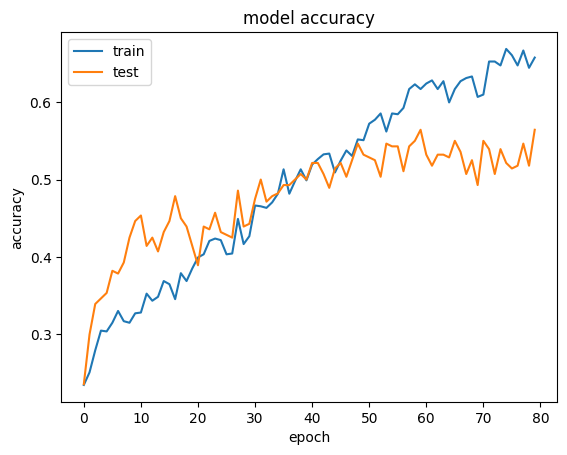

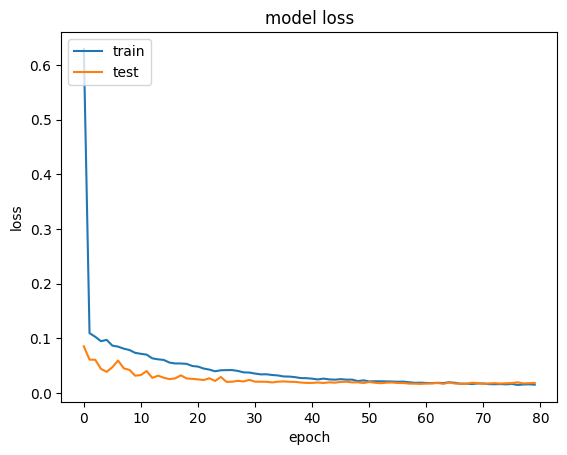

In [148]:
plt.plot(history.history['box_predictions_accuracy'])
plt.plot(history.history['val_box_predictions_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['box_predictions_loss'])
plt.plot(history.history['val_box_predictions_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test

In [139]:
test_img = test_images[74].copy()
test_img = np.array(cv2.resize(test_img, (224, 224)))
test_img = np.expand_dims(test_img, axis=0) 
np.shape(test_img)

(1, 224, 224, 3)

In [140]:
pred = model.predict(test_img)

1/1 [==============================] - 0s 77ms/step


In [141]:
pred

[array([[1.]], dtype=float32),
 array([[0.54927635, 0.50003684, 0.35745353, 0.673501  ]], dtype=float32)]

In [142]:
test_labels[0]

[0.0, 0.2644230769230769, 0.24158653846153846, 0.40625, 0.3125]

In [143]:
pred

[array([[1.]], dtype=float32),
 array([[0.54927635, 0.50003684, 0.35745353, 0.673501  ]], dtype=float32)]

In [144]:
np.shape(pred[0])
np.shape(test_images[0])

(224, 224, 3)

In [145]:
pred_result = np.concatenate((pred[0], pred[1]), axis=1)

In [146]:
pred_result

array([[1.        , 0.54927635, 0.50003684, 0.35745353, 0.673501  ]],
      dtype=float32)

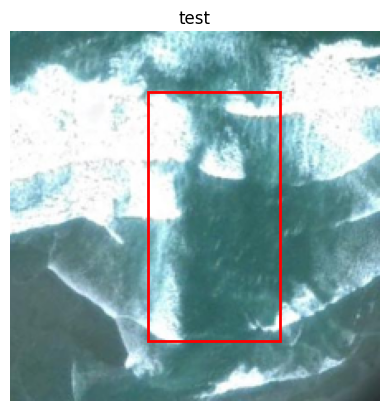

In [147]:
show_data(test_images[74], pred_result[0])

In [149]:
model.save('models/maybeGoodest.h5')

In [150]:
model.save_weights('models/maybeGoodestweights')

### TFLite

In [ ]:

import tensorflow as tf

model = tf.keras.models.load_model('models/maybeGoodest.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("maybeGoodest_fine_tuned.tflite", "wb").write(tflite_model)